<a href="https://colab.research.google.com/github/SizovV/Music_Genres/blob/main/part_2RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ray

     |████████████████████████████████| 23.1MB 1.5MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
     |████████████████████████████████| 204kB 54.5MB/s 
     |████████████████████████████████| 133kB 63.1MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
     |████████████████████████████████| 81kB 11.9MB/s 
     |████████████████████████████████| 2.9MB 43.2MB/s 
     |████████████████████████████████| 1.3MB 41.0MB/s 
     |████████████████████████████████| 61kB 10.5MB/s 
     |████████████████████████████████| 143kB 59.3MB/s 
     |████████████████████████████████| 296kB 61.9MB/s 
     |████████████████████████████████| 102kB 13.9MB/s 
  Created wheel for gpustat: filename=gpustat-0.6.0-cp36-none-any.whl size=12622 sha256=38912247bcf1d78be621267696d9ee7af8b39d34ffee4a95bf0f732076711de7
  Stored in directory: /root/.cache/pip/wheels/48/b4/d5/fb5b7f1d040f2ff20687e3bad6867d63155dbde5a7c10f4293
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl 

In [3]:
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial

In [4]:
import torch
import pandas as pd
import numpy as np 
import os, sys

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import tqdm

%matplotlib inline

In [5]:
data_root = 'drive/MyDrive/data'
data_embeddings = os.path.join(data_root, 'embeddings')

In [6]:
!cp 'drive/MyDrive/data/embeddings_packed.pkl' .

In [7]:
!cp drive/MyDrive/data/*.npy .

In [ ]:
# # convert embeddings' separated files to one file for train, validation and test
# songs = list()
# targets = list()
# for ind in tqdm(data.index):
#   song_name = os.path.join(data_embeddings,
#                                  str(ind) + '.npy')
#   with open(song_name, 'rb') as f:
#       song = np.load(f)
#   target = data.loc[ind]['genre_top']
#   songs.append(song)
#   targets.append(target)

# emb = pd.DataFrame({'song': songs, 'genre': targets})
# emb = emb.set_index(data.index)
# emb.to_pickle(os.path.join(data_root,
#                                  'embeddings_packed.pkl'))

In [8]:
# dataloader
class MusicDataset(torch.utils.data.Dataset):
    """Music dataset."""
 
    def __init__(self, data_file, select):

        self.data = pd.read_pickle(data_file)
        self.classes = {}
        for ind, genre in enumerate(self.data['genre'].unique()):
            self.classes[genre] = ind

        with open(select, 'rb') as f:
            self.select = np.load(f)
 
    def __len__(self):
        return len(self.select)
 
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.data.loc[self.select[idx]]
        return {'song': sample['song'], 'target': self.classes[sample['genre']]}

In [9]:
embd_packed = os.path.join(data_root, 'embeddings_packed.pkl')
data_test = MusicDataset(embd_packed, os.path.join(data_root, 'test.npy'))
torch.manual_seed(42)

In [10]:
def load_data(data_root):
  embd_packed = os.path.join(data_root, 'embeddings_packed.pkl')
  train = MusicDataset(embd_packed, os.path.join(data_root, 'train.npy'))
  val = MusicDataset(embd_packed, os.path.join(data_root, 'val.npy'))
  return train, val

In [11]:
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=100, shuffle=True)

In [12]:
# net
class LSTMClassifier(nn.Module):
    def __init__(self, 
                 hidden_dim, 
                 n_layers,
                 drop1,
                 drop2, 
                 n_classes=8):
        super(LSTMClassifier, self).__init__()
        self.rnn1 = nn.LSTM(128,
                            hidden_dim, 
                            batch_first=True,
                            num_layers=n_layers,
                            dropout=drop1)
        self.drop1 = nn.Dropout(drop2)
        self.fcn1 = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        out, hidden = self.rnn1(x)
        # берём только последний выход
        out = self.drop1(out[:, -1, :])
        out = self.fcn1(out)
        return out

In [13]:
# fit
def train_epoch(
    model,
    data_loader,
    optimizer,
    criterion,
    return_losses=False,
    device='cuda:0',
):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])
    total_labels = np.array([])
    for batch in data_loader:
        # Move Batch to GPU
        songs = batch['song'].to(device)
        labels = batch['target'].to(device)
        predicted = model(songs)
        loss = criterion(predicted, labels)
        # Update weights
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # Update descirption for tqdm
        accuracy = (predicted.argmax(1) == labels).float().mean()
        total_loss += loss.item()
        total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
        total_labels = np.append(total_labels, labels.cpu().detach().numpy())
        num_batches += 1
        all_losses.append(loss.detach().item())
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, criterion, device='cuda:0'):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    for batch in data_loader:
        songs = batch['song'].to(device)
        labels = batch['target'].to(device)
        predicted = model(songs)
        loss = criterion(predicted, labels)
        accuracy = (predicted.argmax(1) == labels).float().mean()
        total_loss += loss.item()
        total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
        total_labels = np.append(total_labels, labels.cpu().detach().numpy())
        num_batches += 1
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return metrics

def fit(
    config,
    checkpoint_dir=None,
    data_dir=None,
    epochs=50,
    patience = 4
):
    model = LSTMClassifier(config['h_layer'], 
                           config['n_layers'], 
                           config['drop1'], 
                           config['drop2'])

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

    if checkpoint_dir:
      model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
      net.load_state_dict(model_state)
      optimizer.load_state_dict(optimizer_state)

    train_data, val_data = load_data(data_dir)

    train_dataloader = torch.utils.data.DataLoader(train_data, 
                                                   batch_size=config['batch_size'], 
                                                   shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, 
                                                 batch_size=config['batch_size'], 
                                                 shuffle=True)
    max_acc = 0
    decrease_counter = 0
    for epoch in range(epochs):
        # Train step
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_dataloader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion
        )
        # Eval step
        with torch.no_grad():
            validation_metrics = validate(
                model=model,
                data_loader=val_dataloader,
                criterion=criterion
            )

        if validation_metrics['accuracy'] > max_acc:
          max_acc = validation_metrics['accuracy']
          decrease_counter = 0
          with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)
        
          tune.report(loss=validation_metrics['loss'], 
                      accuracy=validation_metrics['accuracy'])
        else:
          decrease_counter += 1
        
        if decrease_counter > patience:
          break

In [ ]:
max_epochs = 50
num_samples = 200
patience=4
config = {
        "h_layer": tune.sample_from(lambda _: 2 ** np.random.randint(3, 9)),
        "n_layers": tune.choice([1, 2, 3, 4, 5]),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([16, 32, 64, 128, 256]),
        'drop1': tune.uniform(0, 25e-2),
        'drop2': tune.uniform(0, 25e-2)
    }

scheduler = ASHAScheduler(
    metric="accuracy",
    mode="max",
    max_t=max_epochs,
    grace_period=1,
    reduction_factor=2)

reporter = CLIReporter(
    metric_columns=["loss", "accuracy", "training_iteration"])

result = tune.run(
    partial(fit, data_dir='/content', epochs=max_epochs, patience=patience),
    resources_per_trial={"cpu": 1, "gpu": 1},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter,
    local_dir=data_root)

In [19]:
from ray.tune import Analysis
analysis = Analysis(data_root)

In [22]:
df = analysis.dataframe(metric="accuracy", mode="max")

In [24]:
results_df = df.loc[:, ['loss', 'accuracy', 'experiment_tag']]

In [27]:
best_dir = analysis.get_best_logdir(metric='accuracy', mode='max')

In [29]:
best_config = analysis.get_best_config(metric='accuracy', mode='max')

In [37]:
lstmc = LSTMClassifier(best_config['h_layer'], 
                       best_config['n_layers'],
                       best_config['drop1'],
                       best_config['drop2'])

In [38]:
embd_packed = os.path.join(data_root, 'embeddings_packed.pkl')
data_train = MusicDataset(embd_packed, os.path.join(data_root, 'train.npy'))
data_val = MusicDataset(embd_packed, os.path.join(data_root, 'val.npy'))

train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=best_config['batch_size'], shuffle=True)
val_dataloader = torch.utils.data.DataLoader(data_val, batch_size=best_config['batch_size'], shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstmc.parameters(), lr=best_config['lr'])

In [34]:
def fit_best(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    optimizer,
    criterion
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    epoch_train_acc = []
    epoch_eval_acc = []
    for epoch in range(epochs):
        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_data_loader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion
        )
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics['loss'])
        epoch_train_acc.append(train_metrics['accuracy'])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model,
                data_loader=validation_data_loader,
                criterion=criterion
            )
        # Save eval losses
        epoch_eval_losses.append(validation_metrics['loss'])
        epoch_eval_acc.append(validation_metrics['accuracy'])
    return {'train_loss': epoch_train_losses,
            'train_acc': epoch_train_acc,
            'val_loss': epoch_eval_losses,
            'val_acc': epoch_eval_acc}


In [35]:
h = fit_best(lstmc, 25, train_dataloader, val_dataloader, optimizer, criterion)

Train Epoch: 0
Validation Epoch: 0
Train Epoch: 1
Validation Epoch: 1
Train Epoch: 2
Validation Epoch: 2
Train Epoch: 3
Validation Epoch: 3
Train Epoch: 4
Validation Epoch: 4
Train Epoch: 5
Validation Epoch: 5
Train Epoch: 6
Validation Epoch: 6
Train Epoch: 7
Validation Epoch: 7
Train Epoch: 8
Validation Epoch: 8
Train Epoch: 9
Validation Epoch: 9
Train Epoch: 10
Validation Epoch: 10
Train Epoch: 11
Validation Epoch: 11
Train Epoch: 12
Validation Epoch: 12
Train Epoch: 13
Validation Epoch: 13
Train Epoch: 14
Validation Epoch: 14
Train Epoch: 15
Validation Epoch: 15
Train Epoch: 16
Validation Epoch: 16
Train Epoch: 17
Validation Epoch: 17
Train Epoch: 18
Validation Epoch: 18
Train Epoch: 19
Validation Epoch: 19
Train Epoch: 20
Validation Epoch: 20
Train Epoch: 21
Validation Epoch: 21
Train Epoch: 22
Validation Epoch: 22
Train Epoch: 23
Validation Epoch: 23
Train Epoch: 24
Validation Epoch: 24


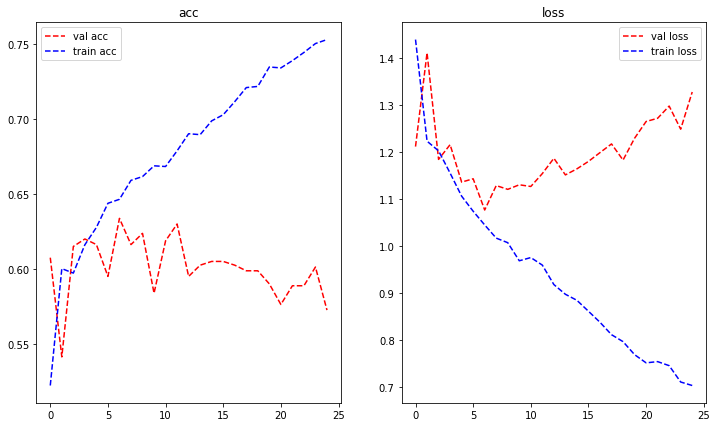

In [36]:
plt.figure(figsize=(12, 7))
plt.subplot(121)
plt.title('acc')
plt.plot(h['val_acc'], 'r--', label='val acc')
plt.plot(h['train_acc'], 'b--', label='train acc')
plt.legend()

plt.subplot(122)
plt.title('loss')
plt.plot(range(len(h['val_loss'])), h['val_loss'], 'r--', label='val loss')
plt.plot(range(len(h['train_loss'])), h['train_loss'], 'b--', label='train loss')
plt.legend()
plt.show()

In [39]:
h = fit_best(lstmc, 6, train_dataloader, val_dataloader, optimizer, criterion)

Train Epoch: 0
Validation Epoch: 0
Train Epoch: 1
Validation Epoch: 1
Train Epoch: 2
Validation Epoch: 2
Train Epoch: 3
Validation Epoch: 3
Train Epoch: 4
Validation Epoch: 4
Train Epoch: 5
Validation Epoch: 5


In [40]:
with torch.no_grad():
            validation_metrics = validate(
                model=lstmc,
                data_loader=test_dataloader,
                criterion=criterion
            )

In [41]:
validation_metrics

{'accuracy': 0.55125, 'loss': 1.303089365363121}